In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Reshape
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, LSTM, Dense, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Reshape, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Layer

In [2]:
def load_images(folder_path, image_size=(64,64)):
    data = []
    labels = []

    label = os.path.basename(folder_path)  # Extract the label from the folder name

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):  # Check if it is a file
            img = cv2.imread(img_path)
            if img is not None:  # Check if the image was read correctly
                img = cv2.resize(img, image_size)  # Resize images to a common size
                data.append(img)
                labels.append(label)

    return np.array(data), np.array(labels)

dataset_path = r"E:\Dataset\Diagnosis of Diabetic Retinopathy\Augmented"

# Load images for each type of chest X-ray
data_DR, labels_DR = load_images(os.path.join(dataset_path, 'DR'))
data_No_DR, labels_No_DR = load_images(os.path.join(dataset_path, 'No_DR'))

In [3]:
data_DR.shape

(6500, 64, 64, 3)

In [4]:
data_No_DR.shape

(6500, 64, 64, 3)

In [5]:
# Combine data and labels for all tumor types
All_data = np.concatenate([data_DR, data_No_DR])
All_labels = np.concatenate([labels_DR, labels_No_DR])

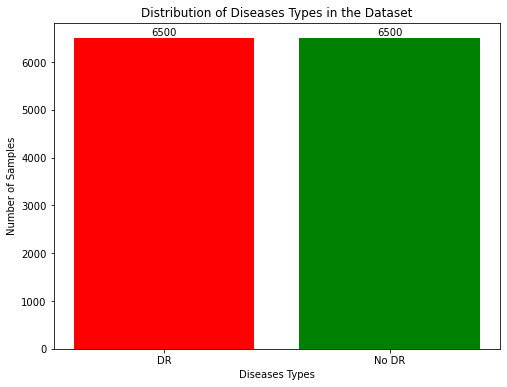

In [6]:
unique_labels, label_counts = np.unique(All_labels, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(unique_labels, label_counts, color=['red', 'green'])
plt.xlabel('Diseases Types')
plt.ylabel('Number of Samples')
plt.title('Distribution of Diseases Types in the Dataset')
for i, count in enumerate(label_counts):
    plt.text(i, count + 20, str(count), ha='center', va='bottom')

plt.xticks(unique_labels, ['DR', 'No DR' ])
plt.show()

In [7]:
# Normalize Pixel Values
All_data_normalized = All_data / 255.0

In [8]:
# Encode Labels
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(All_labels)
train_data, test_data, train_labels, test_labels = train_test_split(
    All_data_normalized, all_labels_encoded, test_size=0.15, random_state=42
)

In [9]:
train_data.shape

(11050, 64, 64, 3)

In [10]:
test_data.shape

(1950, 64, 64, 3)

In [11]:
image_size = (64, 64)
num_classes = 2

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = tf.nn.tanh(tf.tensordot(x, self.W, axes=(2, 0)) + self.b)
        at = tf.nn.softmax(et, axis=1)
        ot = x * at
        return tf.reduce_sum(ot, axis=1)

In [13]:
from tensorflow.keras.models import Model
inputs = Input(shape=(image_size + (3,)))

# CNN layers with Dropout
x = Conv2D(16, kernel_size=(3, 3), activation="relu")(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)  # Adding Dropout after the first max pooling layer
x = Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)  # Adding Dropout after the second max pooling layer
x = Flatten()(x)

# Reshape the output to fit the LSTM input
x = Reshape((1, -1))(x)

# Single LSTM layer with Dropout
lstm_out = LSTM(50, return_sequences=True)(x)
lstm_out = Dropout(0.3)(lstm_out)  # Adding Dropout after LSTM layer

# Attention mechanism
attention_output = Attention()(lstm_out)

# Skip connection to final dense layer
combined_output = Add()([attention_output, tf.reduce_sum(lstm_out, axis=1)])

# Final dense layer
outputs = Dense(num_classes, activation="softmax")(combined_output)

# Define the combined model
combined_model = Model(inputs=inputs, outputs=outputs)

# Compile the model
combined_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Callbacks
checkpoint_callback = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
early_stopping_callback = EarlyStopping(patience=5, monitor="val_loss", mode="min", restore_best_weights=True)

# Model summary
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 62, 62, 16)           448       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 31, 31, 16)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 dropout (Dropout)           (None, 31, 31, 16)           0         ['max_pooling2d[0][0]']   

In [14]:
# Train the model with callbacks
history = combined_model.fit(
    train_data,
    train_labels,
    epochs=40,
    batch_size=16,
    validation_split=0.15,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/40
587/587 [==============================] - ETA: 0s - loss: 0.2691 - accuracy: 0.8878

C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


587/587 [==============================] - 87s 120ms/step - loss: 0.2691 - accuracy: 0.8878 - val_loss: 0.1924 - val_accuracy: 0.9355
Epoch 2/40
587/587 [==============================] - 64s 109ms/step - loss: 0.1809 - accuracy: 0.9392 - val_loss: 0.1743 - val_accuracy: 0.9367
Epoch 3/40
587/587 [==============================] - 61s 104ms/step - loss: 0.1510 - accuracy: 0.9494 - val_loss: 0.1701 - val_accuracy: 0.9433
Epoch 6/40
587/587 [==============================] - 53s 90ms/step - loss: 0.1463 - accuracy: 0.9508 - val_loss: 0.1505 - val_accuracy: 0.9499
Epoch 7/40
587/587 [==============================] - 45s 76ms/step - loss: 0.1390 - accuracy: 0.9538 - val_loss: 0.1563 - val_accuracy: 0.9505
Epoch 8/40
587/587 [==============================] - 44s 74ms/step - loss: 0.1306 - accuracy: 0.9557 - val_loss: 0.1433 - val_accuracy: 0.9505
Epoch 9/40
587/587 [==============================] - 48s 82ms/step - loss: 0.1246 - accuracy: 0.9570 - val_loss: 0.1356 - val_accuracy: 0.9554


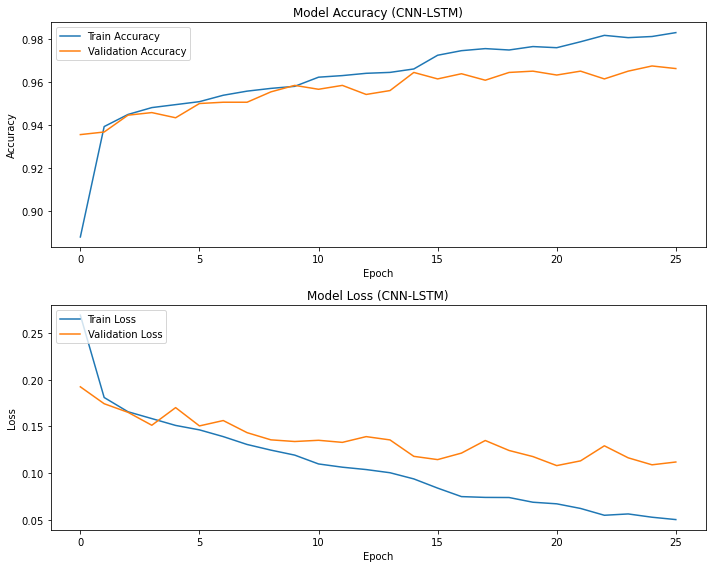

In [15]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot Accuracy
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy (CNN-LSTM)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='upper left')

# Plot Loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss (CNN-LSTM)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [16]:
# Evaluate the model on the test set
test_predictions1 = combined_model.predict(test_data)
test_predictions_classes1 = np.argmax(test_predictions1, axis=1)
CNN_LSTM_class_report1 = classification_report(test_labels, test_predictions_classes1, target_names=label_encoder.classes_)
print("Classification Report:\n", CNN_LSTM_class_report1)

61/61 [==============================] - 7s 55ms/step
Classification Report:
               precision    recall  f1-score   support

          DR       0.96      0.97      0.96      1003
       No_DR       0.96      0.96      0.96       947

    accuracy                           0.96      1950
   macro avg       0.96      0.96      0.96      1950
weighted avg       0.96      0.96      0.96      1950



In [17]:
accuracy = accuracy_score(test_labels, test_predictions_classes1)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 96.15%


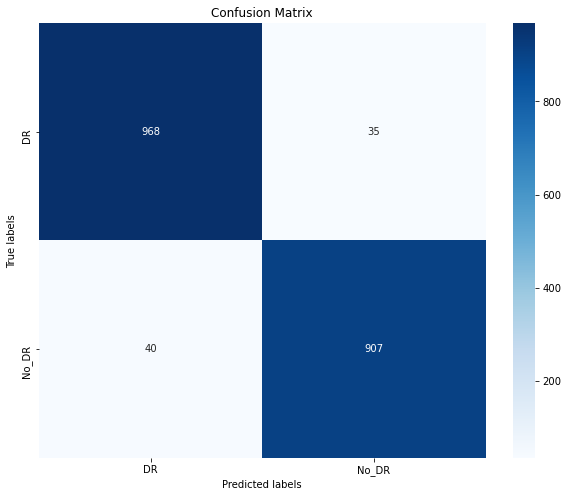

In [18]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions_classes1)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# combined_model.save("trained_combined_model_Attention.h5")

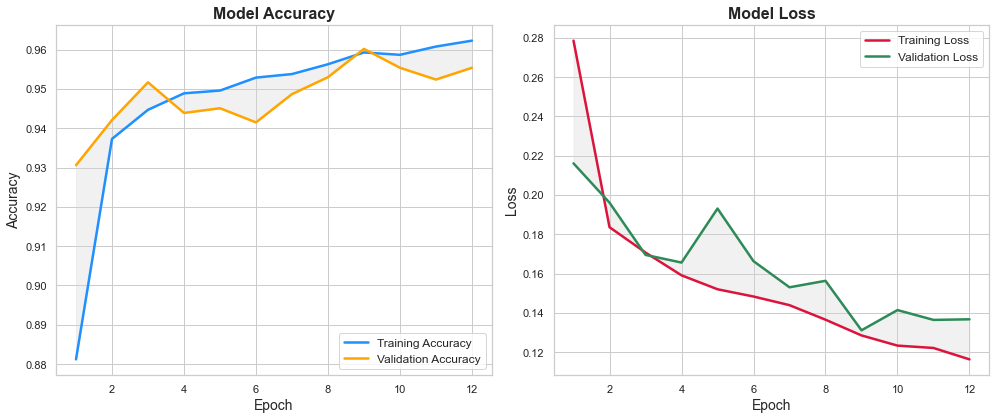

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a beautiful style for the plots
sns.set(style="whitegrid")

# Manually inputting the values based on the provided history
epochs = list(range(1, 13))
train_loss = [0.2786, 0.1836, 0.1707, 0.1591, 0.1520, 0.1483, 0.1439, 0.1365, 0.1285, 0.1233, 0.1221, 0.1163]
train_accuracy = [0.8812, 0.9373, 0.9447, 0.9489, 0.9496, 0.9529, 0.9538, 0.9563, 0.9593, 0.9587, 0.9608, 0.9623]
val_loss = [0.2161, 0.1961, 0.1695, 0.1656, 0.1931, 0.1663, 0.1530, 0.1563, 0.1311, 0.1414, 0.1364, 0.1367]
val_accuracy = [0.9306, 0.9421, 0.9517, 0.9439, 0.9451, 0.9415, 0.9487, 0.9530, 0.9602, 0.9554, 0.9524, 0.9554]

# Plotting training & validation accuracy values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='dodgerblue', linewidth=2.5)
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange', linewidth=2.5)
plt.fill_between(epochs, train_accuracy, val_accuracy, color='lightgray', alpha=0.3)
plt.title('Model Accuracy', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', color='crimson', linewidth=2.5)
plt.plot(epochs, val_loss, label='Validation Loss', color='seagreen', linewidth=2.5)
plt.fill_between(epochs, train_loss, val_loss, color='lightgray', alpha=0.3)
plt.title('Model Loss', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()

In [21]:
train_data.shape

(11050, 64, 64, 3)

In [22]:
test_data.shape

(1950, 64, 64, 3)